In [31]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

Numpy:

In [ ]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None, random_state=0):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        random.seed(random_state)
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

## Ví dụ 1

In [127]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-20, 20], random_state=0): 
    random.seed(random_state)
    np.random.seed(random_state) 
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0] 
    for i in range(k): 
        cov = random.rand(dim, dim+10) 
        cov = np.matmul(cov, cov.T) 
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster) 
        x += list(_x) 
    x = np.array(x) 
    if(dim == 2): 
        fig = plt.figure() 
        ax = fig.gca() 
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4) 
        ax.autoscale(enable=True)  
    return x

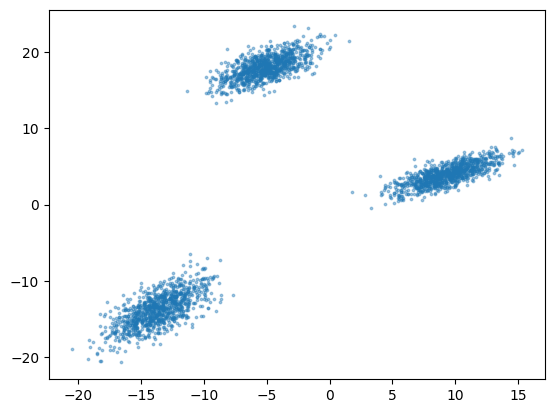

In [128]:
X = gen_data(k=3, dim=2, points_per_cluster=1000, random_state=42)

Iteration: 1, log-likelihood: -17751.0242
Iteration: 2, log-likelihood: -17722.1656
Iteration: 3, log-likelihood: -17687.9107
Iteration: 4, log-likelihood: -17611.5619
Iteration: 5, log-likelihood: -17453.3283
Iteration: 6, log-likelihood: -17178.1237
Iteration: 7, log-likelihood: -16782.0792
Iteration: 8, log-likelihood: -16334.6325
Iteration: 9, log-likelihood: -15846.1417
Iteration: 10, log-likelihood: -14913.9578
Iteration: 11, log-likelihood: -14322.9570
Iteration: 12, log-likelihood: -14322.9570
Iteration: 13, log-likelihood: -14322.9570
Iteration: 14, log-likelihood: -14322.9570
Iteration: 15, log-likelihood: -14322.9570
Iteration: 16, log-likelihood: -14322.9570
Iteration: 17, log-likelihood: -14322.9570
Iteration: 18, log-likelihood: -14322.9570
Iteration: 19, log-likelihood: -14322.9570
Iteration: 20, log-likelihood: -14322.9570



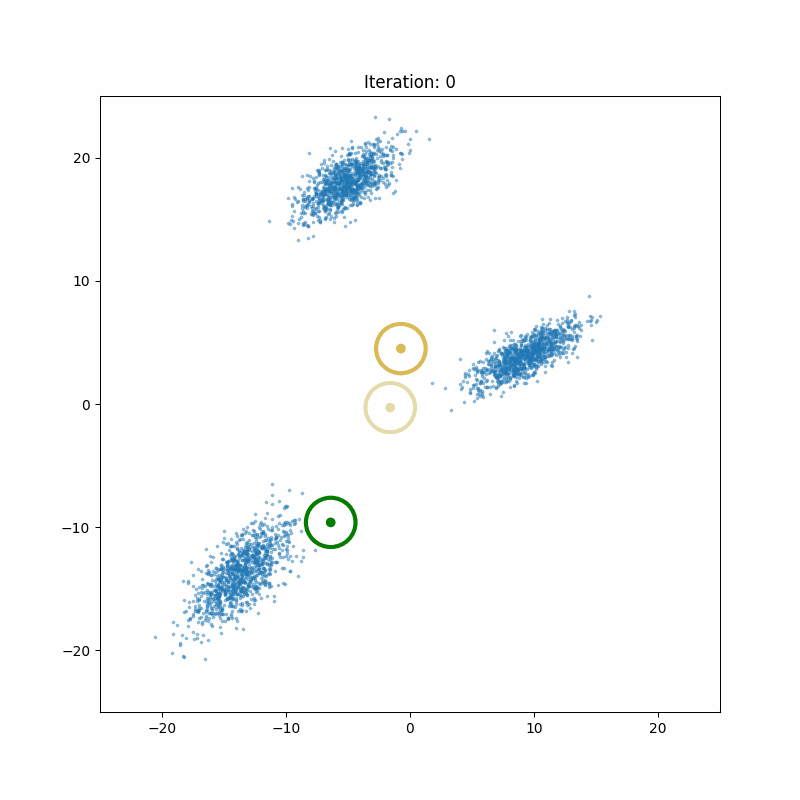

In [140]:
gmm = GMM(3, 2, random_state=11)
gmm.init_em(X)

def plot(title, save_frame=False, frame_path=None):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved
        - save_frame: whether to save the frame
        - frame_path: path to save the frame
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))
    
    plt.title(title)
    
    if save_frame and frame_path:
        plt.savefig(frame_path)
        plt.close()
    else:
        plt.show()
        plt.clf()

# Tạo thư mục để lưu frames tạm thời
temp_dir = 'temp_frames'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

frames = []  # Lưu danh sách các frame paths

num_iters = 20
# Lưu log-likelihood
log_likelihood = [gmm.log_likelihood(X)]

# Lưu frame đầu tiên
frame_path = os.path.join(temp_dir, f'frame_0.png')
plot("Iteration: 0", save_frame=True, frame_path=frame_path)
frames.append(frame_path)

for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print(f"Iteration: {e+1}, log-likelihood: {log_likelihood[-1]:.4f}")
    
    # Lưu frame
    frame_path = os.path.join(temp_dir, f'frame_{e+1}.png')
    plot(f"Iteration: {e+1}", save_frame=True, frame_path=frame_path)
    frames.append(frame_path)

# Tạo GIF từ frames
images = []
for frame in frames:
    images.append(imageio.imread(frame))

# Lưu và hiển thị GIF
imageio.mimsave('gmm_training_vd1.gif', images, duration=0.5)  # 0.5 giây mỗi frame

# Hiển thị GIF trong notebook sử dụng base64 encoding
from IPython.display import HTML
import base64

# Đọc file GIF và encode thành base64
with open('gmm_training_vd1.gif', 'rb') as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode('utf-8')

# Hiển thị GIF
HTML(f'<img src="data:image/gif;base64,{gif_base64}" />')


## Bài 1

In [27]:
from sklearn import datasets
# import some data to play with
iris = datasets.load_iris()
X, y = iris.data, iris.target

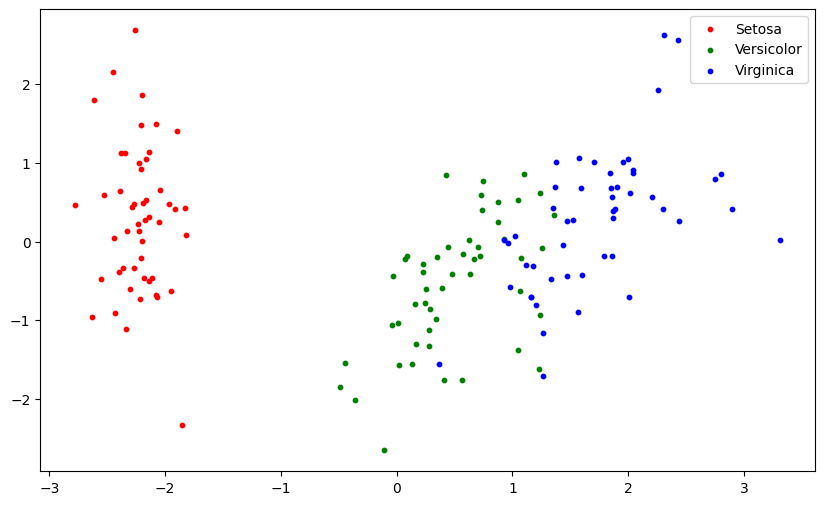

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X0 = X_pca[y == 0, :]
X1 = X_pca[y == 1, :]
X2 = X_pca[y == 2, :]   

plt.figure(figsize=(10, 6))
plt.scatter(X0[:, 0], X0[:, 1], c='r', s=10, label='Setosa')
plt.scatter(X1[:, 0], X1[:, 1], c='g', s=10, label='Versicolor')
plt.scatter(X2[:, 0], X2[:, 1], c='b', s=10, label='Virginica')
plt.legend()
plt.show()

Iteration: 1, log-likelihood: -482.6044
Iteration: 2, log-likelihood: -474.9523
Iteration: 3, log-likelihood: -469.6506
Iteration: 4, log-likelihood: -462.7187
Iteration: 5, log-likelihood: -444.9544
Iteration: 6, log-likelihood: -423.9555
Iteration: 7, log-likelihood: -409.4301
Iteration: 8, log-likelihood: -399.3682
Iteration: 9, log-likelihood: -392.5952
Iteration: 10, log-likelihood: -386.5636
Iteration: 11, log-likelihood: -382.2265
Iteration: 12, log-likelihood: -380.8613
Iteration: 13, log-likelihood: -380.3770
Iteration: 14, log-likelihood: -380.0906
Iteration: 15, log-likelihood: -379.9056
Iteration: 16, log-likelihood: -379.7843
Iteration: 17, log-likelihood: -379.7018
Iteration: 18, log-likelihood: -379.6411
Iteration: 19, log-likelihood: -379.5916
Iteration: 20, log-likelihood: -379.5466
Iteration: 21, log-likelihood: -379.5022
Iteration: 22, log-likelihood: -379.4560
Iteration: 23, log-likelihood: -379.4071
Iteration: 24, log-likelihood: -379.3555
Iteration: 25, log-likeli


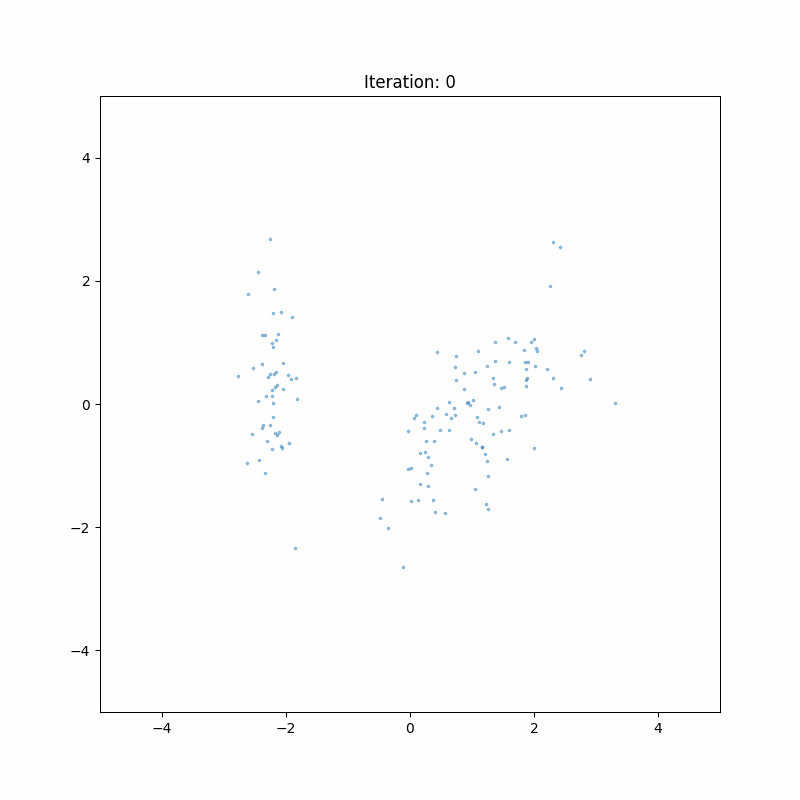

In [118]:
gmm = GMM(3, 2, random_state=31)
gmm.init_em(X_pca)

def plot(title, save_frame=False, frame_path=None):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved
        - save_frame: whether to save the frame
        - frame_path: path to save the frame
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    
    plt.title(title)
    
    if save_frame and frame_path:
        plt.savefig(frame_path)
        plt.close()
    else:
        plt.show()
        plt.clf()

# Tạo thư mục để lưu frames tạm thời
temp_dir = 'temp_frames'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

frames = []  # Lưu danh sách các frame paths

num_iters = 50
# Lưu log-likelihood
log_likelihood = [gmm.log_likelihood(X_pca)]

# Lưu frame đầu tiên
frame_path = os.path.join(temp_dir, f'frame_0.png')
plot("Iteration: 0", save_frame=True, frame_path=frame_path)
frames.append(frame_path)

for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X_pca))
    print(f"Iteration: {e+1}, log-likelihood: {log_likelihood[-1]:.4f}")
    
    # Lưu frame
    frame_path = os.path.join(temp_dir, f'frame_{e+1}.png')
    plot(f"Iteration: {e+1}", save_frame=True, frame_path=frame_path)
    frames.append(frame_path)

# Tạo GIF từ frames
images = []
for frame in frames:
    images.append(imageio.imread(frame))

# Lưu và hiển thị GIF
imageio.mimsave('gmm_training.gif', images, duration=0.5)  # 0.5 giây mỗi frame

# Hiển thị GIF trong notebook sử dụng base64 encoding
from IPython.display import HTML
import base64

# Đọc file GIF và encode thành base64
with open('gmm_training.gif', 'rb') as f:
    gif_data = f.read()
gif_base64 = base64.b64encode(gif_data).decode('utf-8')

# Hiển thị GIF
HTML(f'<img src="data:image/gif;base64,{gif_base64}" />')

Kết quả phân cụm tương đối trùng khớp với phân lớp của dữ liệu

## Bài 2

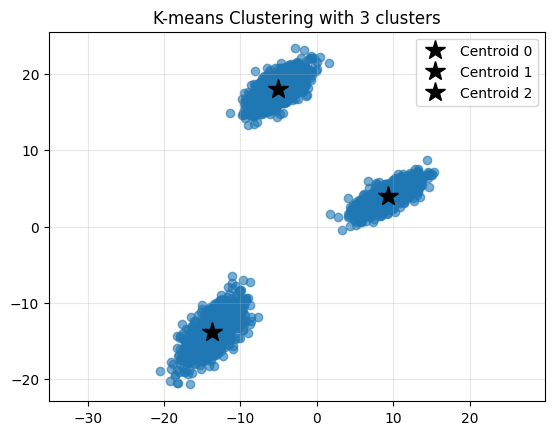

In [146]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit_predict(X)

def kmeans_display(X, centers=None):
    K = 3
    # Vẽ các điểm theo từng cụm
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    
    # Vẽ các tâm cụm nếu có
    if centers is not None:
        for i in range(K):
            plt.plot(centers[i, 0], centers[i, 1], '*',
                    color='black',
                    markersize=15,
                    label=f'Centroid {i}')
    
    plt.title(f'K-means Clustering with {K} clusters')
    plt.legend()
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()
kmeans_display(X, kmeans.cluster_centers_.squeeze())

## Ví dụ 2

In [147]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import itertools 
from scipy import linalg 
import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects 
from matplotlib.patches import Ellipse 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.mixture import GaussianMixture

In [148]:
data = pd.read_csv("shopping-data.csv", header=0, index_col=0) 
print(data.shape) 
data.head() 
 
# Lấy ra thu nhập va điểm shopping 
X = data.iloc[:, 2:4].values 
 
# Chuẩn hoá dữ liệu 
std = MinMaxScaler() 
X_std = std.fit_transform(X) 
print(X_std.shape)

(200, 4)
(200, 2)


In [149]:
# Khởi tạo đối tượng mô hình GaussianMixture 
gm = GaussianMixture(n_components=5, 
                     covariance_type='full', 
                     random_state=0) 
gm.fit(X_std) 
print('means: \n', gm.means_) 
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


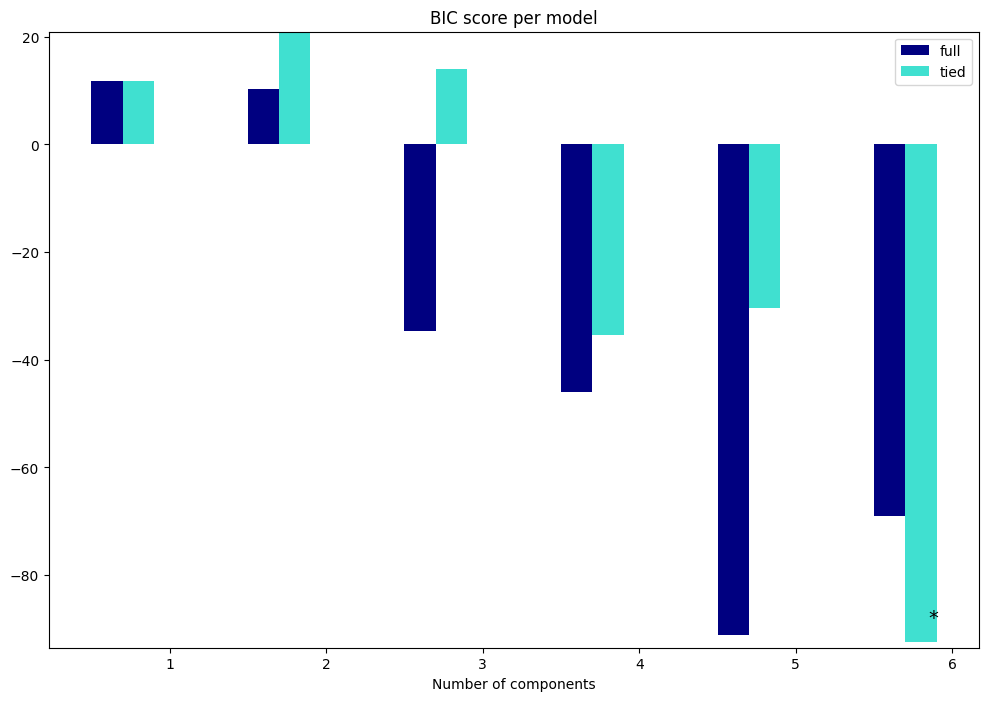

In [152]:
lowest_bic = np.infty 
bic = [] 
n_components_range = range(1, 7) 
# cv_types = ['spherical', 'tied', 'diag', 'full'] 
cv_types = ['full', 'tied'] 
for cv_type in cv_types: 
    for n_components in n_components_range: 
        # Fit Gaussian mixture theo phương pháp huấn luyện EM 
        gmm = GaussianMixture(n_components=n_components, 
                                      covariance_type=cv_type) 
        gmm.fit(X_std) 
        bic.append(gmm.bic(X_std)) 
        # Gán model có BIC scores thấp nhất là model tốt nhất 
        if bic[-1] < lowest_bic: 
            lowest_bic = bic[-1] 
            best_gmm = gmm 
 
bic = np.array(bic) 
color_iter = itertools.cycle(['navy', 'turquoise']) 
clf = best_gmm 
bars = [] 
 
# Vẽ biểu đồ BIC scores 
plt.figure(figsize=(12, 8)) 
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)): 
    xpos = np.array(n_components_range) + .2 * (i - 2) 
    bars.append(plt.bar(xpos, bic[i * len(n_components_range): 
                                  (i + 1) * len(n_components_range)], 
                        width=.2, color=color)) 
plt.xticks(n_components_range) 
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()]) 
plt.title('BIC score per model') 
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range)) 
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14) 
plt.xlabel('Number of components') 
plt.legend([b[0] for b in bars], cv_types)

In [155]:
def _plot_kmean_scatter(X, labels): 
    ''' 
    X: dữ liệu đầu vào 
    labels: nhãn dự báo 
    ''' 
    # lựa chọn màu sắc 
    num_classes = len(np.unique(labels)) 
    palette = np.array(sns.color_palette("hls", num_classes)) 
 
    # vẽ biểu đồ scatter 
    fig = plt.figure(figsize=(12, 8)) 
    ax = plt.subplot() 
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40,  c=palette[labels.astype(np.int8)]) 
 
    # thêm nhãn cho mỗi cluster 
    txts = [] 
 
    for i in range(num_classes): 
        # Vẽ text tên cụm tại trung vị của mỗi cụm 
        xtext, ytext = np.median(X[labels == i, :], axis=0) 
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([ 
            PathEffects.Stroke(linewidth=5, foreground="w"), 
            PathEffects.Normal()]) 
        txts.append(txt) 
    plt.title('t-sne visualization')

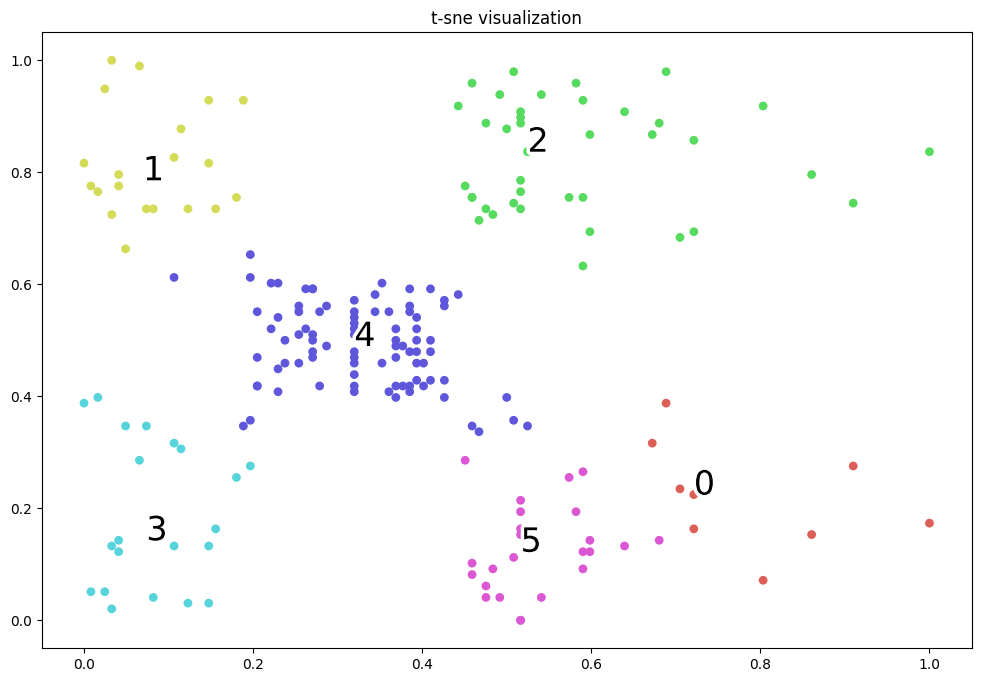

In [156]:
labels = best_gmm.predict(X_std) 
_plot_kmean_scatter(X_std, labels) 

## Ví dụ mở rộng

In [164]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv', index_col=0)
data = data.iloc[:, 54:]
print(data.shape)

(811, 52)


In [165]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

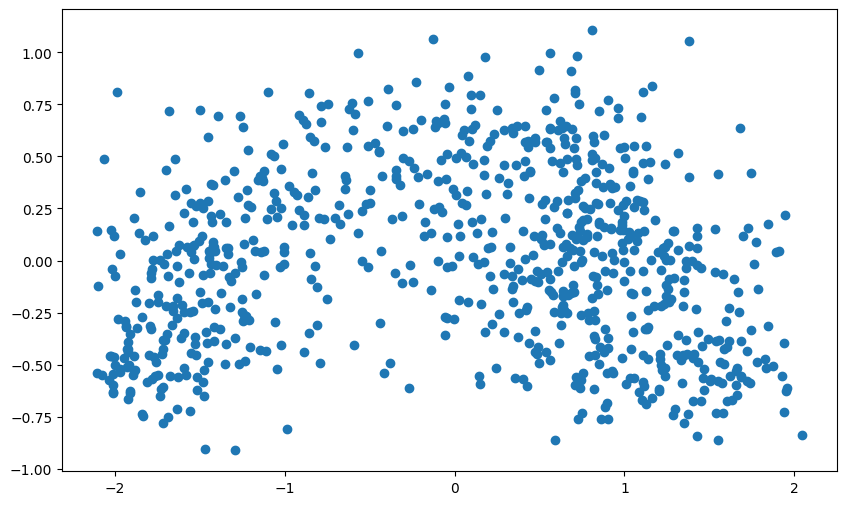

In [169]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [188]:
def plot_gaussian(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

def draw(gmm, k, ax, n_std=2.0, **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        colors = plt.cm.rainbow(np.linspace(0, 1, k))
        for i in range(k):
            plot_gaussian(gmm.means_[i], gmm.covariances_[i], ax, n_std=n_std, edgecolor=colors[i], **kwargs)

In [194]:
def plot(gmm, k, title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1])
    draw(gmm, k, ax, lw=3)
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    plt.title(title)

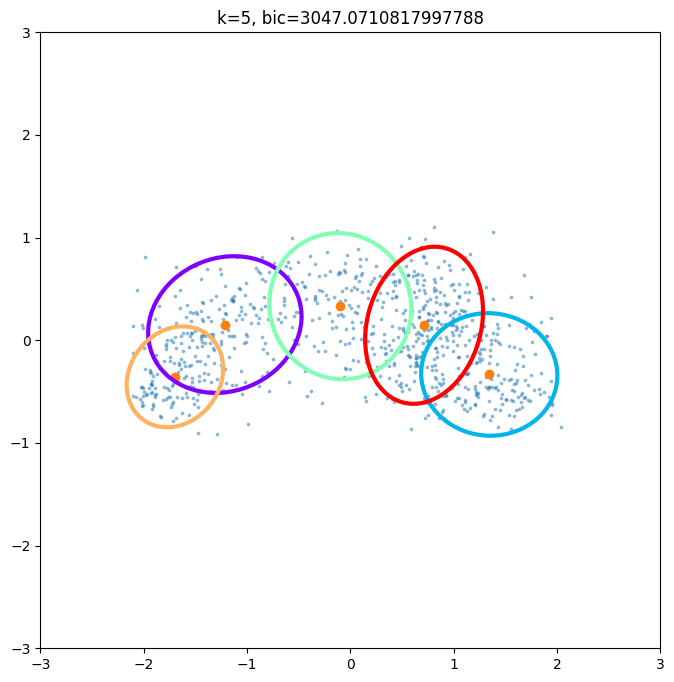

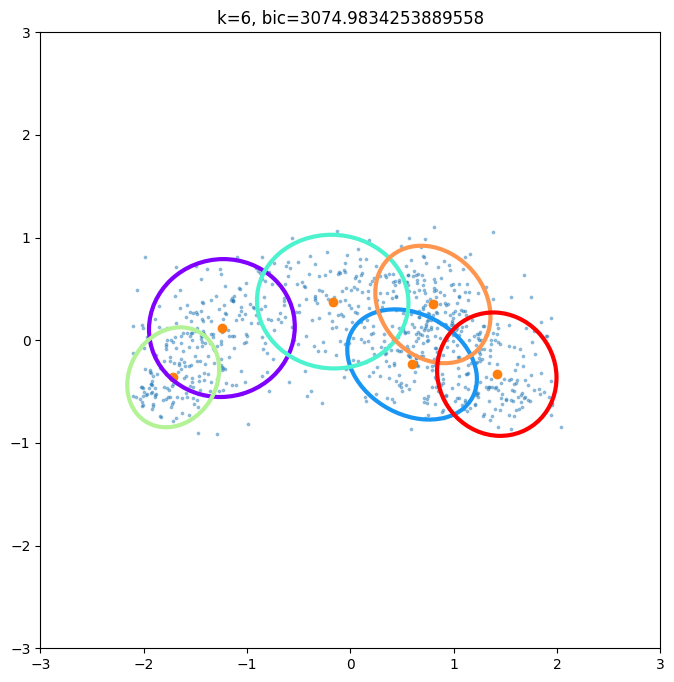

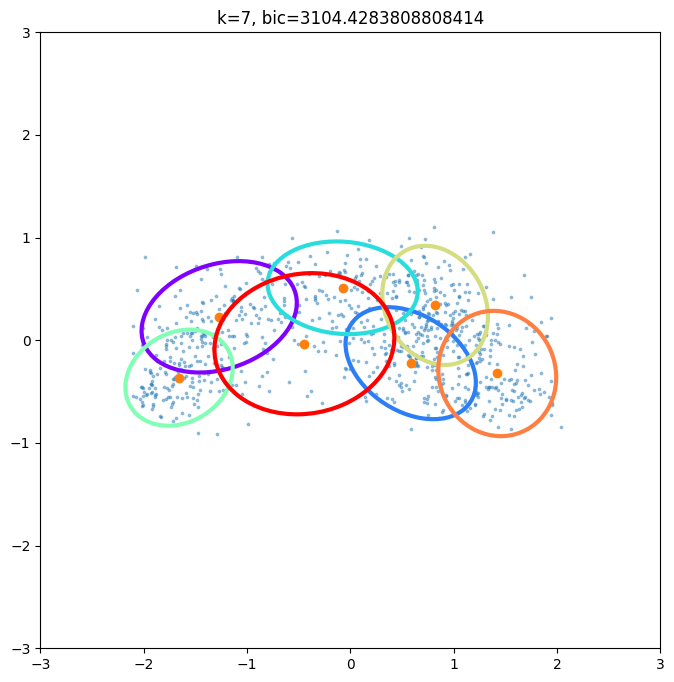

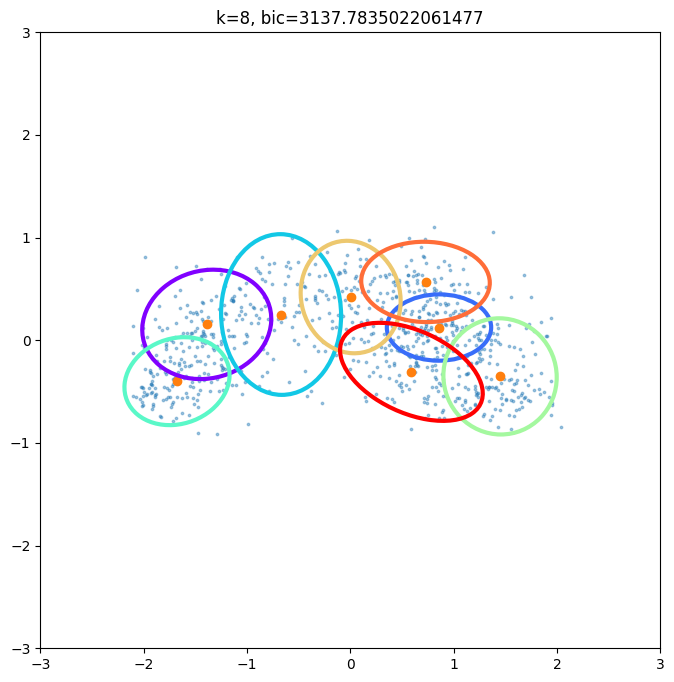

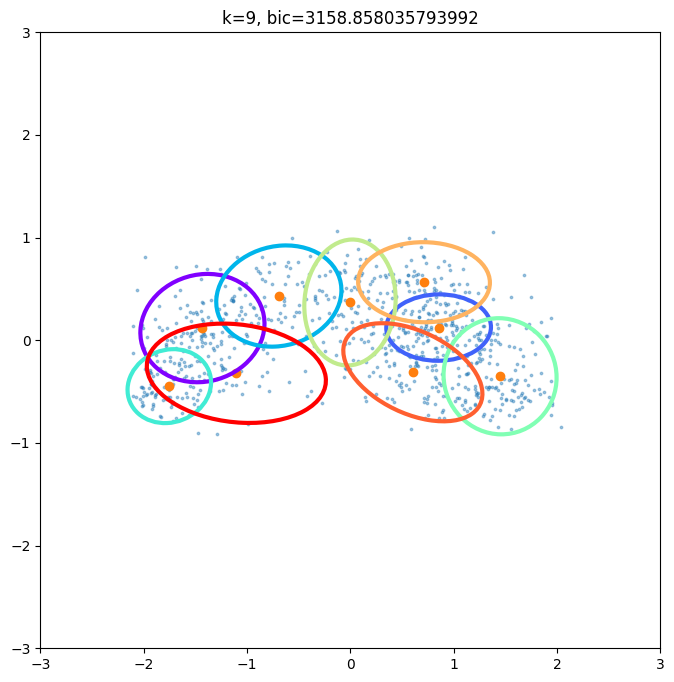

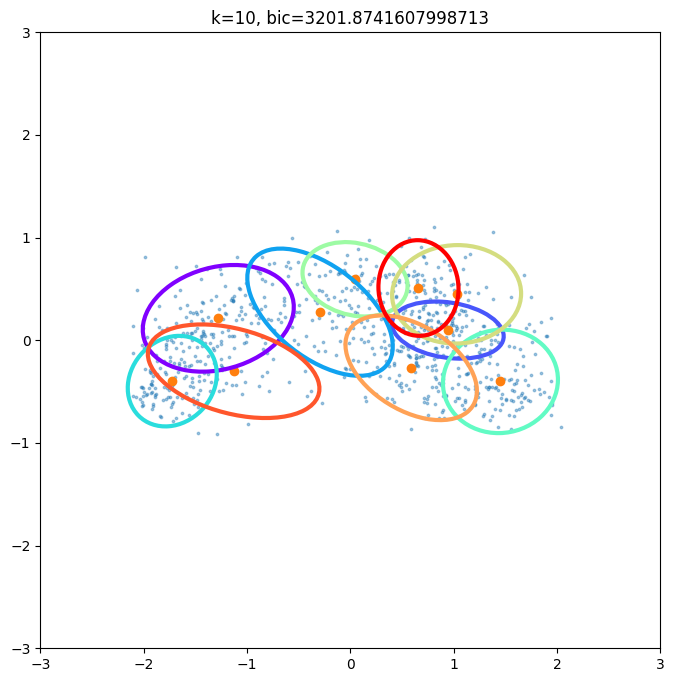

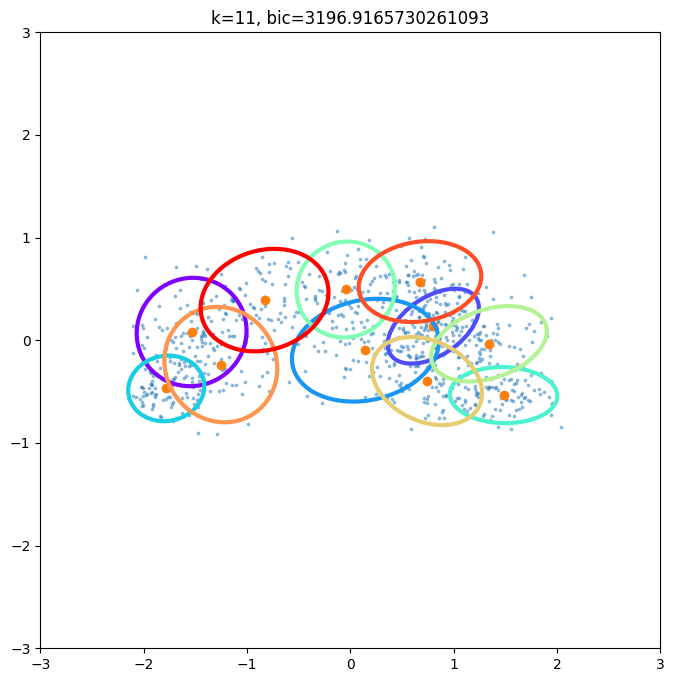

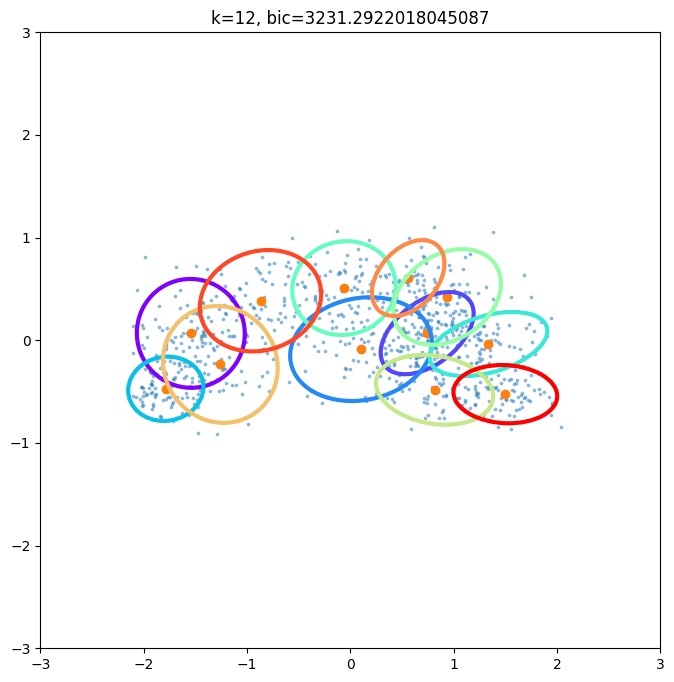

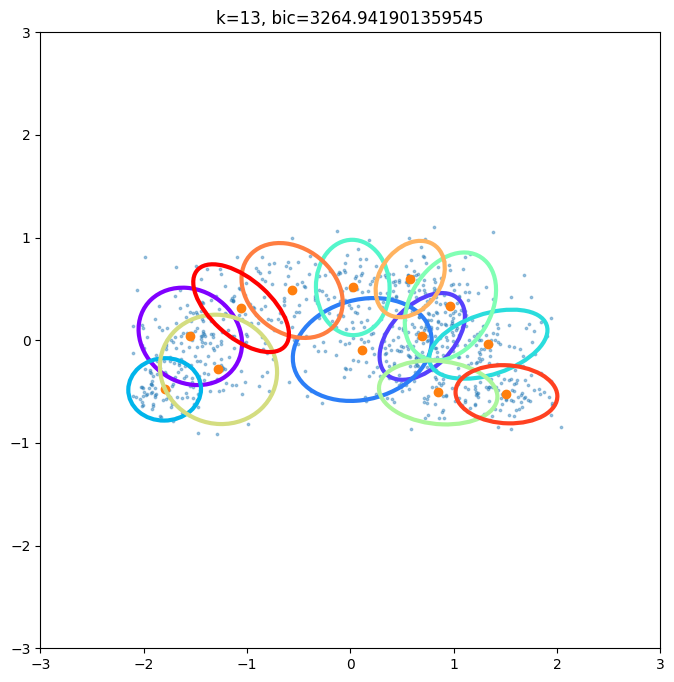

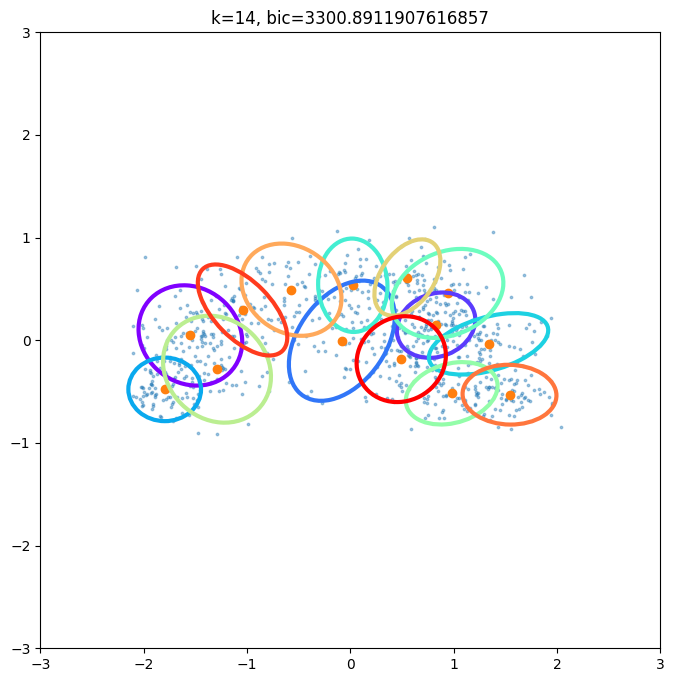

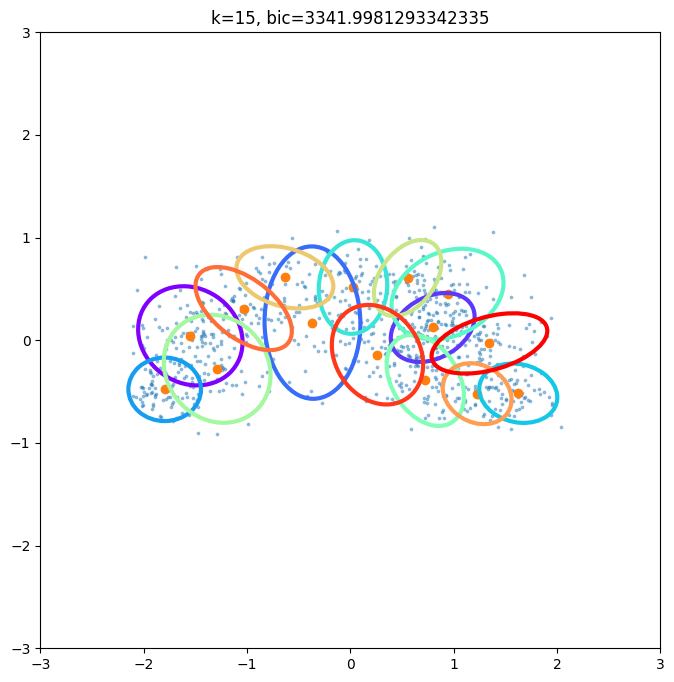

In [195]:
for k in range(5, 16):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0) 
    gmm.fit(X_pca)
    plot(gmm, k, f'k={k}, bic={gmm.bic(X_pca)}')